# FUCCI Cell Cycle Analysis
- *Bel Taylor-Hearn, 2025*
- Experimental data acquired by Marcus Preedy

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import os
import pathlib
from tifffile import imread

from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, erosion, disk, closing, dilation
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border, watershed
from skimage.color import label2rgb

from scipy import ndimage as ndi

import napari

import trackpy as tp

In [2]:
def convert(img, target_type_min, target_type_max, target_type):
    """
    Converts an image to a specified data type while scaling its intensity values.

    This function rescales the intensity values of an image from its original range 
    to a new target range specified by `target_type_min` and `target_type_max`, and 
    then converts it to the desired data type.

    This step is required as deconvolved images are not always scaled 0->255! 

    Parameters:
    -----------
    img : numpy.ndarray
        The input image array to be converted.
    target_type_min : int or float
        The minimum value of the target intensity range.
    target_type_max : int or float
        The maximum value of the target intensity range.
    target_type : numpy.dtype
        The desired data type of the output image (e.g., np.uint8, np.float32).

    Returns:
    --------
    new_img : numpy.ndarray
        The rescaled image with values mapped to the new intensity range and converted 
        to the specified data type.

    Notes:
    ------
    - This function performs a linear transformation to scale pixel values.
    - It ensures that the output values are properly mapped between `target_type_min` and 
      `target_type_max`.
    """
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

In [3]:
def classify_color(row):
    """
    Classifies a nucleus based on the dominant fluorescent signal within its segmented area.

    The classification logic is as follows:
      - If more than 15% of the nucleus area is double-positive (both red and green), it is labeled 'yellow'.
      - Otherwise, the nucleus is classified as 'red' or 'green' depending on which signal is more abundant.

    This function is intended to be used with `pandas.DataFrame.apply()` on a row-wise basis.

    Parameters
    ----------
    row : pd.Series
        A row from a DataFrame that includes '%red', '%green', and '%yellow' columns.

    Returns
    -------
    str
        A string label: one of 'yellow', 'red', or 'green', representing the dominant signal.
    """
    if row['%yellow'] > 15: # you can use Napari/any image viewer to change this cutoff to match your definition of double positive
        return 'yellow'
    elif row['%red'] > row['%green']:
        return 'red'
    else:
        return 'green'

In [27]:
def extract_nuclei(image_path, red_channel = 1, green_channel=3):
    """
    Extracts and segments nuclei from a 4D timelapse fluorescence image using intensity thresholding,
    morphological operations, and watershed segmentation.

    Red and green channels are combined to create a combined nuclear signal. This combined image is 
    segmented to create "all_combined_nuclei" (no colour dependence)

    Individual red and green channels are also segmented independently to create "all_green_nuclei"
    and "all_red_nuclei": binary masks denoting green/red-positive nuclei

    Parameters
    ----------
    image_path : str
        Path to the 4D image file (time, channel, height, width) containing nuclear stains.

    Returns
    -------
    all_combined_nuclei : np.ndarray
        3D array of labeled nuclei (t, y, x) from combined red and green signals.

    all_red_nuclei : np.ndarray
        3D binary mask (t, y, x) of nuclei detected from the red channel.

    all_green_nuclei : np.ndarray
        3D binary mask (t, y, x) of nuclei detected from the green channel.
    """
    timelapse_image = imread(image_path)
    red_channel = convert(timelapse_image[:,red_channel,:,:], 0,255, np.uint8)
    green_channel = convert(timelapse_image[:,green_channel,:,:], 0, 255, np.uint8)
    combined_nuclear_channel = convert((red_channel + green_channel), 0, 255, np.uint8)
    stacked_nuclei = []
    for t in range(combined_nuclear_channel.shape[0]):
        combined_nuclear_thresh = threshold_otsu(combined_nuclear_channel[t,:,:])
        combined_nuclei = combined_nuclear_channel[t,:,:] > combined_nuclear_thresh
        combined_nuclei = closing(combined_nuclei, disk(2))
        combined_nuclei = remove_small_objects(combined_nuclei, min_size=100)
    #####################SEPARATE TOUCHING NUCLEI####################
        distances = ndi.distance_transform_edt(erosion(combined_nuclei, disk(2)))
        coordinates = peak_local_max(distances, min_distance = 8) 
        marker_locations = coordinates.data
        markers = np.zeros(combined_nuclei.shape, dtype=np.uint32)
        marker_indices = tuple(np.round(marker_locations).astype(int).T)
        markers[marker_indices] = np.arange(len(marker_locations)) + 1
        markers_big = dilation(markers, disk(2))
        segmented_nuclei = watershed(-distances, markers_big, mask=combined_nuclei)
        segmented_nuclei = clear_border(segmented_nuclei)
        nuclear_labels = label(segmented_nuclei)
        stacked_nuclei.append(nuclear_labels)
    all_combined_nuclei = np.stack(stacked_nuclei, axis=0)
    # Idenfify red nuclei, green nuclei, and yellow nuclei (nuclei that are red and green)
    for i, nuclear_channel in enumerate([red_channel, green_channel]):
        stacked_nuclei = []
        for t in range(red_channel.shape[0]):
            nuclear_thresh = threshold_otsu(nuclear_channel[t,:,:])
            nuclei = nuclear_channel[t,:,:] > nuclear_thresh
            nuclei = closing(nuclei, disk(2))
            nuclei = remove_small_objects(nuclei, min_size=100)
            stacked_nuclei.append(nuclei)
        #####################SEPARATE TOUCHING NUCLEI####################
        if i == 0:
            all_red_nuclei = np.stack(stacked_nuclei, axis=0)
        else:
            all_green_nuclei = np.stack(stacked_nuclei, axis=0)
    # all_yellow_nuclei = ((all_red_nuclei > 0) & (all_green_nuclei > 0)).astype(np.uint8)
    return all_combined_nuclei, all_red_nuclei, all_green_nuclei#, all_yellow_nuclei

In [28]:
def link_and_filter_nuclear_tracks(all_combined_nuclei, all_red_nuclei, all_green_nuclei, proportion_of_frames = 0.2):
    """
    Uses TrackPy to link nuclei in subsequent timeframes, filters for long-lived tracks, then
    quantifies nuclear colour (red, green, yellow) for each tracked nucleus

    This function performs the following steps:
      - Extracts centroid positions of labeled nuclei from the combined label mask.
      - Uses TrackPy to link nuclei across time into tracks based on proximity and persistence.
      - Filters for tracks that persist for at least proportion_of_frames*100% of the total timepoints.
      - For each remaining nucleus in each frame, computes the proportion of nuclear area 
        occupied by red-only, green-only, and yellow (dual-positive) signals.
      - Classifies each nucleus as red, green, yellow, or unclassified using a helper function.

    Parameters
    ----------
    all_combined_nuclei : np.ndarray
        3D array of labeled nuclei over time, shape (T, H, W).

    all_red_nuclei : np.ndarray
        3D binary mask of red channel nuclei over time, shape (T, H, W).

    all_green_nuclei : np.ndarray
        3D binary mask of green channel nuclei over time, shape (T, H, W).

    proportion_of_frames: np.float
        proportion (0,1) of frames that a cell must be identified in to be quantified

    Returns
    -------
    long_tracks : pd.DataFrame
        DataFrame containing linked and filtered nuclear tracks with:
        - frame, x, y: coordinates over time
        - particle: unique track ID
        - %red, %green, %yellow: percentage of nucleus covered by each color
        - color: classified color identity of the nucleus
    """
    # Link nuclei first
    nuclei_data = []
    for t in range(all_combined_nuclei.shape[0]):
        labels_t = all_combined_nuclei[t]
        props = regionprops(labels_t)
        
        for prop in props:
            y, x = prop.centroid
            nuclei_data.append({'frame': t, 'x': x, 'y': y})

    nuclei_df = pd.DataFrame(nuclei_data)
    linked_df = tp.link_df(nuclei_df, search_range=20, memory=2) # can update based on your best guess -> can use napari to validate
    # Filter long-lived tracks
    particle_frame_counts = linked_df.groupby('particle')['frame'].nunique()
    min_required_frames = all_red_nuclei.shape[0] * proportion_of_frames
    long_lived_particles = particle_frame_counts[particle_frame_counts > min_required_frames].index
    long_tracks = linked_df[linked_df['particle'].isin(long_lived_particles)].copy()
    # Round for indexing
    long_tracks['x_rounded'] = long_tracks['x'].round().astype(int)
    long_tracks['y_rounded'] = long_tracks['y'].round().astype(int)

    # Initialize color percentage columns
    long_tracks['%red'] = np.nan
    long_tracks['%green'] = np.nan
    long_tracks['%yellow'] = np.nan

    # Compute %red, %green, %yellow only for nuclei in long_tracks
    for idx, row in long_tracks.iterrows():
        t = int(row['frame'])
        x = int(row['x_rounded'])
        y = int(row['y_rounded'])

        if 0 <= y < all_combined_nuclei.shape[1] and 0 <= x < all_combined_nuclei.shape[2]:
            label_id = all_combined_nuclei[t, y, x]
            if label_id == 0:
                continue

            nucleus_mask = all_combined_nuclei[t] == label_id
            total_area = nucleus_mask.sum()
            if total_area == 0:
                continue

            red_mask = all_red_nuclei[t]
            green_mask = all_green_nuclei[t]
            yellow_mask = (red_mask > 0) & (green_mask > 0)

            red_area = (nucleus_mask & red_mask).sum()
            green_area = (nucleus_mask & green_mask).sum()
            yellow_area = (nucleus_mask & yellow_mask).sum()

            red_unique = red_area - yellow_area
            green_unique = green_area - yellow_area

            long_tracks.at[idx, '%red'] = 100 * red_unique / total_area
            long_tracks.at[idx, '%green'] = 100 * green_unique / total_area
            long_tracks.at[idx, '%yellow'] = 100 * yellow_area / total_area

    long_tracks['color'] = long_tracks.apply(classify_color, axis=1)
    return long_tracks


In [ ]:
def test_segmentation_parameters(path, all_combined_nuclei, all_red_nuclei, all_green_nuclei, t=20):
    """
    Visualises segmentation results for a selected timepoint from a 4D timelapse image, 
    allowing qualitative assessment of nuclear segmentation and channel-specific masks.

    This function displays four side-by-side panels:
      1. Raw merged image (red + green channels)
      2. Combined segmentation overlay (labelled nuclei from both channels)
      3. Red channel with red-positive nuclei overlay
      4. Green channel with green-positive nuclei overlay

    The overlays use transparent labels to show alignment between the raw image 
    and the segmentation results.

    Parameters
    ----------
    path : str
        File path to the original 4D timelapse image with shape (T, C, Y, X).

    all_combined_nuclei : np.ndarray
        Labeled mask of all segmented nuclei, shape (T, Y, X), from combined red and green channels.

    all_red_nuclei : np.ndarray
        Binary mask of nuclei positive in the red channel, shape (T, Y, X).

    all_green_nuclei : np.ndarray
        Binary mask of nuclei positive in the green channel, shape (T, Y, X).

    t: np.int
        Timepoint to visualise

    Returns
    -------
    None
        Displays and saves a figure (`example_outputs.pdf`) showing overlay comparisons.
    """
    test = imread(path)
    fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

    # Panel 1: Raw merged image
    ax[0].imshow(test[t, 1, :, :] + test[t, 3, :, :], cmap="gray")
    ax[0].set_title("Merged raw image (red + green)")

    # Panel 2: Combined nuclear segmentation
    ax[1].imshow(test[t, 1, :, :] + test[t, 3, :, :], cmap="gray")
    overlay_combined = label2rgb(all_combined_nuclei[t, :, :], bg_label=0, alpha=0.5)
    ax[1].imshow(overlay_combined)
    ax[1].set_title("Segmented nuclei (combined mask)")

    # Panel 3: Red channel + red nuclei overlay
    ax[2].imshow(test[t, 1, :, :], cmap="Reds")
    overlay_red = label2rgb(label(all_red_nuclei[t, :, :]), bg_label=0, alpha=0.4, image=test[t, 1, :, :], kind='overlay')
    ax[2].imshow(overlay_red)
    ax[2].set_title("Red channel with red nuclei mask")

    # Panel 4: Green channel + green nuclei overlay
    ax[3].imshow(test[t, 3, :, :], cmap="Greens")
    overlay_green = label2rgb(label(all_green_nuclei[t, :, :]), bg_label=0, alpha=0.4, image=test[t, 3, :, :], kind='overlay')
    ax[3].imshow(overlay_green)
    ax[3].set_title("Green channel with green nuclei mask")

    # Tidy up
    for a in ax:
        a.axis("off")

    plt.tight_layout()
    plt.savefig("example_outputs.pdf")
    plt.show()

In [29]:
def plot_tracks(long_tracks, color_map = {"red": "red", "green": "limegreen", "yellow": "gold", "none": "gray"}):
    """
    Plots nuclear tracks over time, colored by their classified identity (red, green, yellow, or none).

    Each track is visualized as a series of connected line segments in 2D (x, y) space.
    The color of each segment corresponds to the nuclear classification at that timepoint.

    Parameters
    ----------
    long_tracks : pd.DataFrame
        DataFrame of linked and classified nuclear tracks. Must include:
        - 'x', 'y' positions
        - 'particle' track ID
        - 'color' classification for each frame

    color_map : dict, optional
        Mapping from classification labels ('red', 'green', 'yellow', 'none') to matplotlib color names.
        Defaults to red, limegreen, gold, and gray.

    Returns
    -------
    None
        Displays a matplotlib plot of all tracked nuclei with color-coded trajectories.
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    all_x = []
    all_y = []

    for particle_id, track in long_tracks.groupby("particle"):
        track = track.sort_values("frame")
        coords = track[["x", "y"]].to_numpy()
        all_x.extend(track["x"].values)
        all_y.extend(track["y"].values)


        segments = np.stack([coords[:-1], coords[1:]], axis=1)
        segment_colors = [color_map.get(c, "gray") for c in track["color"].iloc[:-1]]
        lc = LineCollection(segments, colors=segment_colors, linewidths=1.5, alpha=0.8)
        ax.add_collection(lc)

        ax.set_xlim(min(all_x) - 10, max(all_x) + 10)
        ax.set_ylim(min(all_y) - 10, max(all_y) + 10)
        ax.invert_yaxis()  

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Colour and Trajectory")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.savefig("Output_trajectories.pdf")
    plt.show()


In [30]:
image_paths = list(pathlib.Path("C:/Users/itayl/Dropbox (Personal)/Python/Data_For_Others/Marcus/MOVED_FUCCI").rglob("*.{}".format("tif")))
all_combined_nuclei, all_red_nuclei, all_green_nuclei = extract_nuclei(image_paths[0])

In [31]:
all_combined_nuclei.shape, all_red_nuclei.shape, all_green_nuclei.shape

((83, 1024, 1024), (83, 1024, 1024), (83, 1024, 1024))

In [32]:
long_tracks = link_and_filter_nuclear_tracks(all_combined_nuclei, all_red_nuclei, all_green_nuclei)

Frame 82: 113 trajectories present.


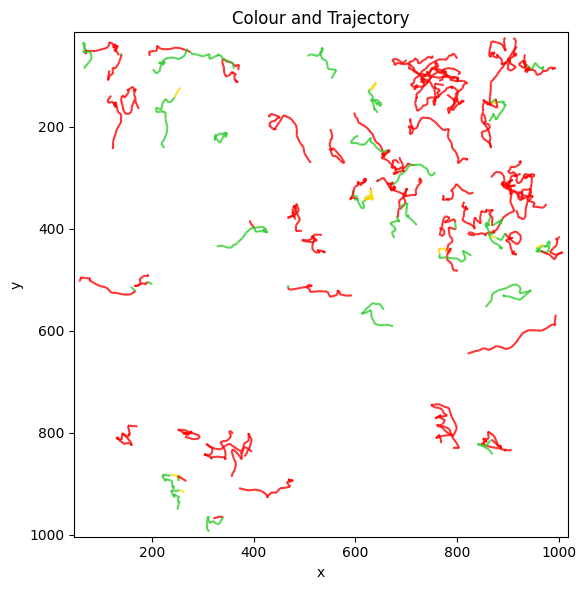

In [33]:
plot_tracks(long_tracks)

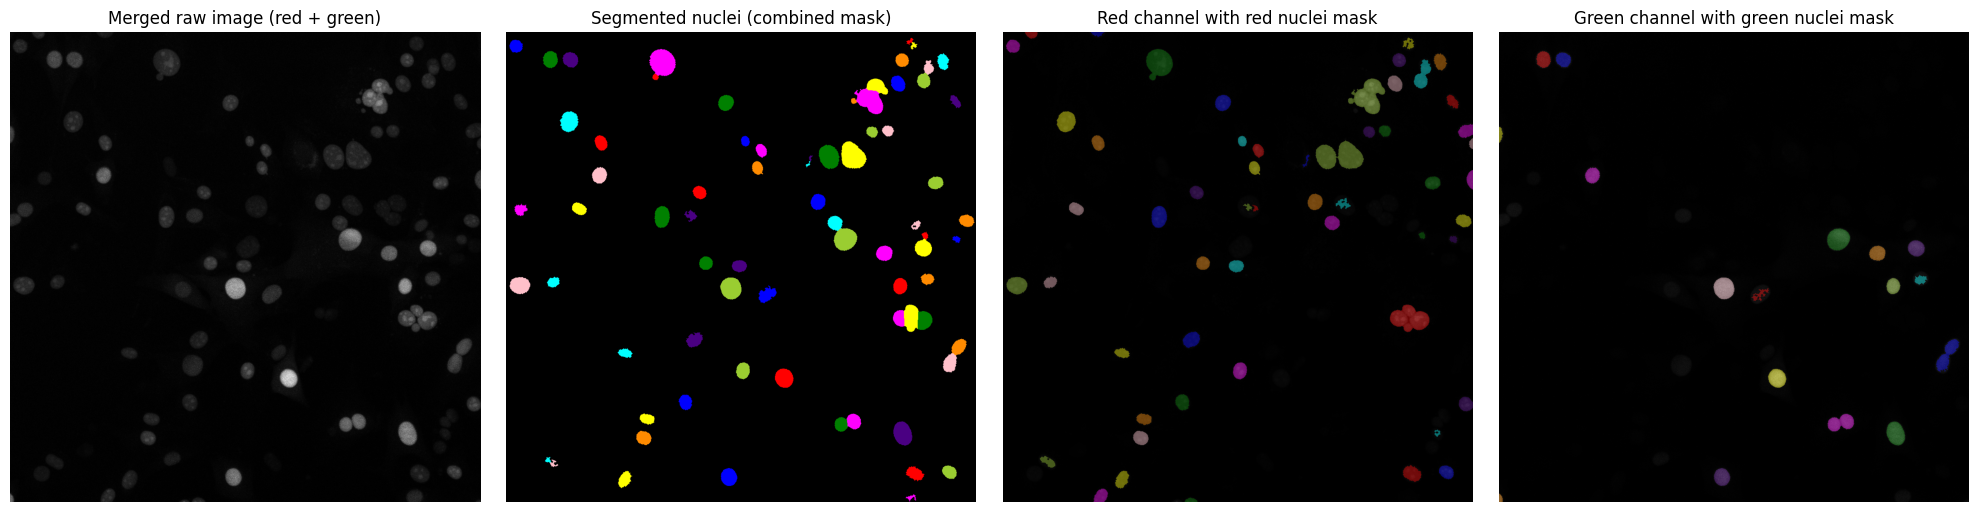

In [ ]:
test_segmentation_parameters(image_paths[0], all_combined_nuclei, all_red_nuclei, all_green_nuclei)